<a href="https://colab.research.google.com/github/aadomingos/energyUsageInsights/blob/master/tempNormalizedUsage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

To start, set up the notebook with the basic required libraries and to access the data.

In [ ]:
# python imports
import pandas as pd
import numpy as np
import datetime
import pytz
import json

# graphic imports
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mount your Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# write path to your Google Drive folder that contains the data
usagePath = '/content/drive/My Drive/Colab Notebooks/data/SRP/hourlyUsage.csv'

# Import and Setup Data

Import the data.

In [ ]:
# read usage data into pandas dataframe
usageData_df = pd.read_csv(usagePath)

# get info about the dataframe
print(usageData_df.info())

# check the first few rows of the dataframe
print(usageData_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9528 entries, 0 to 9527
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Usage date  9528 non-null   object 
 1   Interval    9528 non-null   object 
 2   Total kWh   9528 non-null   float64
dtypes: float64(1), object(2)
memory usage: 223.4+ KB
None
  Usage date Interval  Total kWh
0   7/1/2019  12:0 am        1.1
1   7/1/2019   1:0 am        0.4
2   7/1/2019   2:0 am        1.0
3   7/1/2019   3:0 am        0.9
4   7/1/2019   4:0 am        0.3


Transform the dataframe to be later used in eeMeter.

In [ ]:
# combine the usage date and interval columns for eeMeter
usageData_df['start'] = usageData_df['Usage date'] + ' ' + usageData_df['Interval']

# convert the concatenated column to a datetime object
usageData_df['start'] = pd.to_datetime(usageData_df['start'], infer_datetime_format=True)

# create a datetime index for the dataframe from the datetime column and resample to set the frequency
usageData_df = usageData_df.set_index(pd.DatetimeIndex(usageData_df['start'], tz='America/Phoenix'))\
    .resample('H').mean()

# set the timezone to UTC
usageData_df = usageData_df.tz_convert('UTC')

In [ ]:
# change column name for eeMeter (to be used later)
usageData_df.rename(columns={'Total kWh':'value'}, inplace=True)

# Import Weather From eeWeather

Install and import eeWeather.

In [ ]:
# install eeWeather
!pip install eeweather

In [ ]:
# import eeWeather
import eeweather

Find weather for the energy meter zip code.

In [ ]:
# convert zip code/ZCTA to coordinates
lat, lng = eeweather.zcta_to_lat_long('85008')

In [ ]:
# rank stations by distance from zip code/ZCTA
rankedStations_df = eeweather.rank_stations(lat, lng)
rankedStations_df.head(10)

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722780,1,4231.377100,33.428,-112.004,2,B,Hot-Dry,None,high,337.4,AZ,I,True,False,None
722789,2,19058.646831,33.623,-111.911,2,B,Hot-Dry,None,high,449.0,AZ,II,True,False,None
722783,3,23592.962364,33.467,-111.733,2,B,Hot-Dry,None,low,420.6,AZ,None,False,False,None
722784,4,26443.924819,33.688,-112.082,2,B,Hot-Dry,None,high,443.5,AZ,II,True,False,None
722749,5,26943.183693,33.269,-111.813,2,B,Hot-Dry,None,medium,378.9,AZ,None,False,False,None
722787,6,29502.363911,33.527,-112.295,2,B,Hot-Dry,None,medium,324.9,AZ,None,False,False,None
722786,7,34832.708252,33.300,-111.667,2,B,Hot-Dry,None,high,421.2,AZ,None,False,False,None
722785,8,36615.287081,33.550,-112.367,2,B,Hot-Dry,None,medium,330.7,AZ,II,True,False,None
722788,9,37201.220560,33.417,-112.383,2,B,Hot-Dry,None,medium,295.1,AZ,None,False,False,None


In [ ]:
# select station with rank 1
selectedStation, warnings = eeweather.select_station(rankedStations_df)

# print weather station ID and warnings
print('This is the selected weather station: ISD', selectedStation)
print('These are the warnings for this station:', warnings)

This is the selected weather station: ISD 722780
These are the warnings for this station: []


In [ ]:
# find only high quality weather stations that match the station above
highQualityStations_df = eeweather.rank_stations(
    lat, lng,
    match_iecc_climate_zone=True,
    match_iecc_moisture_regime=True,
    match_ba_climate_zone=True,
    match_ca_climate_zone=True,
    minimum_quality='high',  # find stations with reported high frequency data
    is_tmy3=True,            # find stations with TMY3 normal year data
)

highQualityStations_df.head()

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722780,1,4231.377100,33.428,-112.004,2,B,Hot-Dry,None,high,337.4,AZ,I,True,False,None
722789,2,19058.646831,33.623,-111.911,2,B,Hot-Dry,None,high,449.0,AZ,II,True,False,None
722784,3,26443.924819,33.688,-112.082,2,B,Hot-Dry,None,high,443.5,AZ,II,True,False,None
722740,4,176549.590786,32.131,-110.955,2,B,Hot-Dry,None,high,776.9,AZ,I,True,False,None


In [ ]:
# this is the timezone where this energy usage originated
phoenix = pytz.timezone('America/Phoenix')

# format for timestamps
fmt = '%Y-%m-%d %H:%M %Z%z'

# start date for weather data (start date for energy usage)
start_date = datetime.datetime(2019, 7, 1, 0, 0, tzinfo=phoenix)
start_date = start_date.astimezone(pytz.timezone('UTC'))

# end date for weather data (end date for energy usage)
end_date = datetime.datetime(2020, 7, 31, 23, 0, tzinfo=phoenix)
end_date = end_date.astimezone(pytz.timezone('UTC'))

# find the weather station with the highest coverage
station, warnings = eeweather.select_station(
    highQualityStations_df,
    coverage_range=(start_date, end_date),
    min_fraction_coverage=0.99,
    rank=1
)

print('weather statioin ID ', station)
print('start date ', start_date.strftime(fmt))
print('end date ', end_date.strftime(fmt))

weather statioin ID  722780
start date  2019-07-01 07:28 UTC+0000
end date  2020-08-01 06:28 UTC+0000


In [ ]:
# check weather station meta-data
highQualityStations_df.loc[station.usaf_id]
# print(json.dumps(station.json(), indent=2))

rank                                 1
distance_meters                4231.38
latitude                        33.428
longitude                     -112.004
iecc_climate_zone                    2
iecc_moisture_regime                 B
ba_climate_zone                Hot-Dry
ca_climate_zone                   None
rough_quality                     high
elevation                        337.4
state                               AZ
tmy3_class                           I
is_tmy3                           True
is_cz2010                        False
difference_elevation_meters       None
Name: 722780, dtype: object

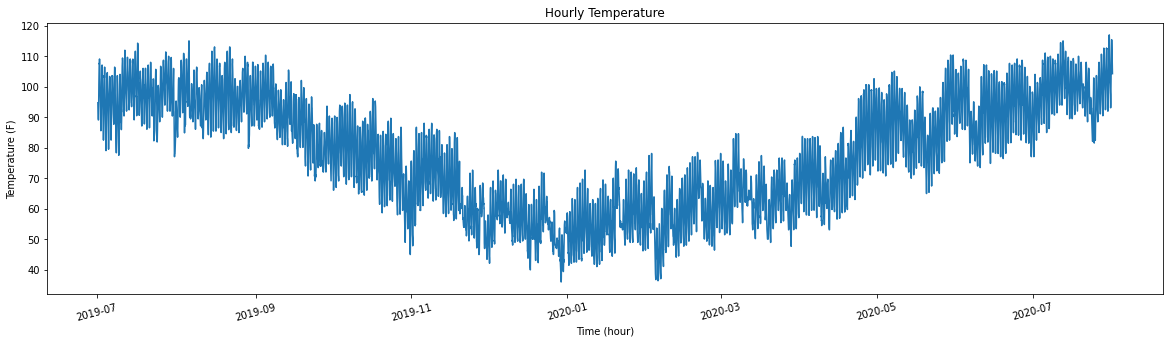

In [ ]:
# get temperature from weather station
temp_C = station.load_isd_hourly_temp_data(start_date, end_date)

# convert from Celsius to Fahrenheit
tempF = temp_C[0].mul(1.8).add(32)
tempF.index.rename('dt', inplace=True)
tempF.rename('tempF', inplace=True)

# plot temperature for visualization
plt.figure(figsize=(20,5))
sns.lineplot(data=tempF)
plt.xticks(rotation=15)
plt.xlabel('Time (hour)')
plt.ylabel('Temperature (F)')
plt.title('Hourly Temperature')
plt.show()

# Import eeMeter

In [ ]:
# install eemeter
!pip install git+https://github.com/aadomingos/eemeter/

  Cloning https://github.com/aadomingos/eemeter/ to /tmp/pip-req-build-_6fc9ru3
  Running command git clone -q https://github.com/aadomingos/eemeter/ /tmp/pip-req-build-_6fc9ru3
  Created wheel for eemeter: filename=eemeter-2.9.2-cp36-none-any.whl size=583129 sha256=3eaed386535d6bec5f4aab3ad85cbc95cf29880453b9fc1977a53da8a96b0710
  Stored in directory: /tmp/pip-ephem-wheel-cache-q4og9yrl/wheels/47/e7/fa/462b7c9d9f48edfa485ac1cdc92b131aec217332bb9e39a0de
Successfully built eemeter


In [ ]:
# import eeMeter
import eemeter

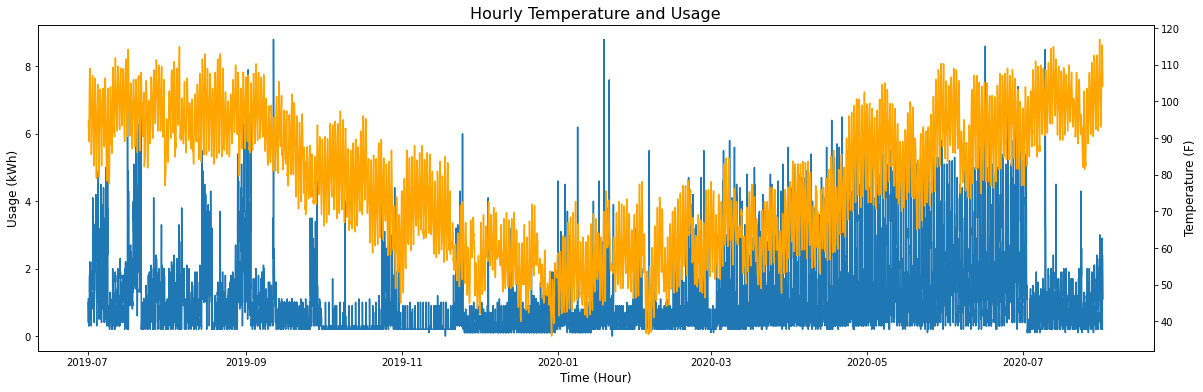

In [ ]:
# # visualizing energy and temperature usage
# eemeter.plot_time_series(usageData_df, tempF, figsize=(16, 4))

# create first y-axis for usage graph
fig, ax1 = plt.subplots(figsize=(20,6))
g = sns.lineplot(x=usageData_df.index, y='value', data=usageData_df, ax=ax1)

# set the axis labels
ax1.set_title('Hourly Temperature and Usage', fontsize=16)
ax1.set_ylabel('Usage (kWh)', fontsize=12)
ax1.set_xlabel('Time (Hour)', fontsize=12)

# create a second y-axis for temperature graph
color = 'orange'
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=tempF, color=color)
ax2.set_ylabel('Temperature (F)', fontsize=12)

# show graph
plt.show()

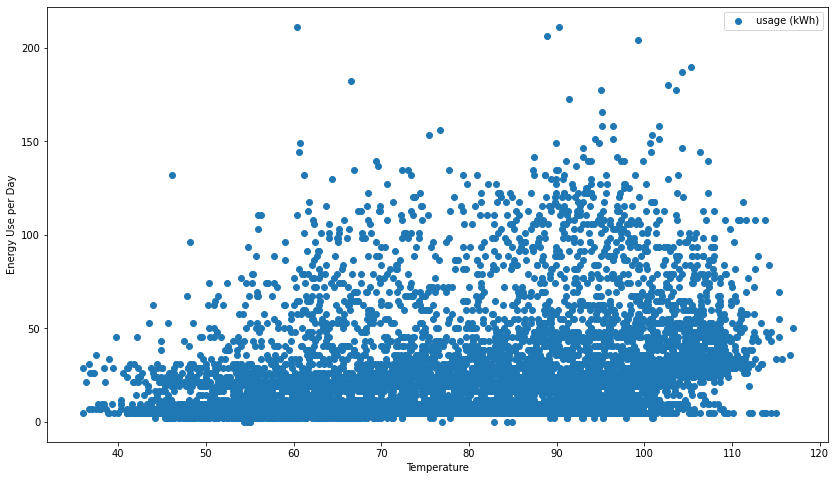

In [ ]:
# display energy usage signature
ax = eemeter.plot_energy_signature(usageData_df, tempF, figsize=(14, 8))
ax.legend(labels=['usage (kWh)'])

In [ ]:
# create a design matrix for occupancy and segmentation
preliminary_design_matrix = (
    eemeter.create_caltrack_hourly_preliminary_design_matrix(
        usageData_df, tempF,
    )
)

# preliminary design matrix
preliminary_design_matrix.head(5)

,meter_value,temperature_mean,cdd_65,hdd_50,n_hours_dropped,n_hours_kept,hour_of_week
start,,,,,,,
2019-07-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 08:00:00+00:00,0.4,94.70660,29.70660,0.0,0.0,1.0,8
2019-07-01 09:00:00+00:00,1.0,93.32096,28.32096,0.0,0.0,1.0,9
2019-07-01 10:00:00+00:00,0.9,91.07816,26.07816,0.0,0.0,1.0,10
2019-07-01 11:00:00+00:00,0.3,89.39156,24.39156,0.0,0.0,1.0,11


In [ ]:
# build 12 monthly models - each step from now on operates on each segment
segmentation = eemeter.segment_time_series(
    preliminary_design_matrix.index,
    'three_month_weighted'
)

In [ ]:
# assign an occupancy status to each hour of the week (0-167)
occupancy_lookup = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix,
    segmentation=segmentation,
)

occupancy_lookup.head(25)

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
hour_of_week,,,,,,,,,,,,
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,False,False
5,False,False,False,True,True,False,False,False,False,False,False,False
6,False,False,False,True,True,False,False,False,False,False,False,False
7,False,False,False,False,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# assign temperatures to bins
temperature_bins_hourly = eemeter.fit_temperature_bins(
    preliminary_design_matrix,
    segmentation=segmentation,
    default_bins=[40, 55, 65, 75, 85, 95, 105, 112],  # default
    min_temperature_count=10  # default
    )

temperature_bins_hourly

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
bin_endpoints,,,,,,,,,,,,
40,True,True,True,False,False,False,False,False,False,False,False,False
55,True,True,True,True,True,False,False,False,True,True,True,True
65,True,True,True,True,True,False,False,False,True,True,True,True
75,True,True,True,True,True,True,False,True,True,True,True,True
85,False,False,True,True,True,True,True,True,True,True,True,True
95,False,False,True,True,True,True,True,True,True,True,False,False
105,False,False,False,True,True,True,True,True,True,True,False,False
112,False,False,False,False,False,True,True,True,True,False,False,False


In [ ]:
# build a design matrix for each monthly segment
segmented_design_matrices = (
    eemeter.create_caltrack_hourly_segmented_design_matrices(
        preliminary_design_matrix,
        segmentation,
        occupancy_lookup,
        temperature_bins_hourly,
    )
)

In [ ]:
# build a CalTRACK hourly model
hourly_model = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices,
    occupancy_lookup,
    temperature_bins_hourly,
)

In [ ]:
model_results = eemeter.CalTRACKHourlyModelResults(
        status="SUCCESS",
        method_name="caltrack_hourly",
        model=hourly_model,
    )

In [ ]:
metered_savings_dataframe, error_bands = eemeter.metered_savings(
    hourly_model, usageData_df,
    tempF, with_disaggregated=True
)

In [ ]:
metered_savings_dataframe

,reporting_observed,counterfactual_usage,metered_savings
start,,,
2019-07-01 07:00:00+00:00,NaN,NaN,NaN
2019-07-01 08:00:00+00:00,0.4,0.780588,0.380588
2019-07-01 09:00:00+00:00,1.0,0.859913,-0.140087
2019-07-01 10:00:00+00:00,0.9,0.652056,-0.247944
2019-07-01 11:00:00+00:00,0.3,0.775855,0.475855
...,...,...,...
2020-08-01 02:00:00+00:00,2.4,1.943274,-0.456726
2020-08-01 03:00:00+00:00,2.0,2.246525,0.246525
2020-08-01 04:00:00+00:00,1.7,2.150060,0.450060


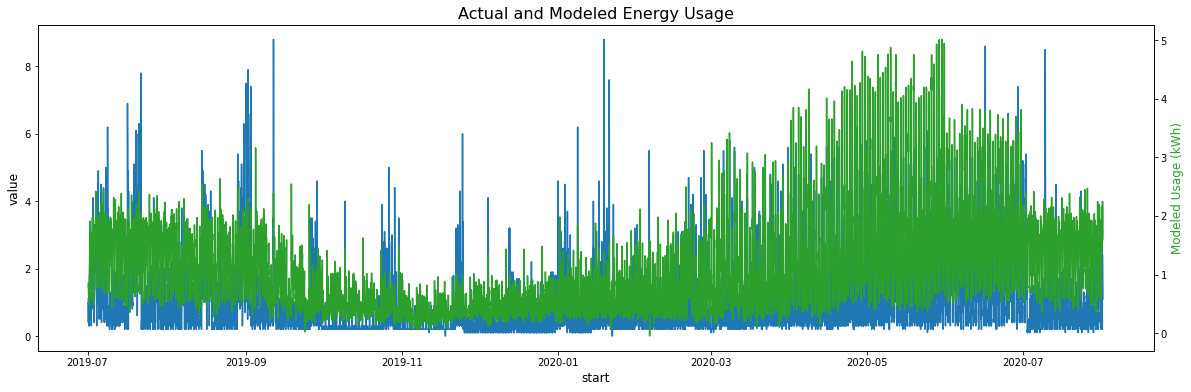

In [ ]:
# create first y-axis for usage graph
fig, ax1 = plt.subplots(figsize=(20,6))
color = 'tab:green'
# set the axis labels
ax1.set_title('Actual and Modeled Energy Usage', fontsize=16)
ax1.set_ylabel('Actual Usage (kWh)', fontsize=12)
ax1.set_xlabel('Time (Hour)', fontsize=12)
ax2 = sns.lineplot(data=usageData_df, x=usageData_df.index, y='value')

# create a second y-axis for temperature graph
color = 'tab:green'
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=metered_savings_dataframe.counterfactual_usage, color=color, hue='metered_savings')
ax2.set_ylabel('Modeled Usage (kWh)', fontsize=12, color=color)

# show graph
plt.show()

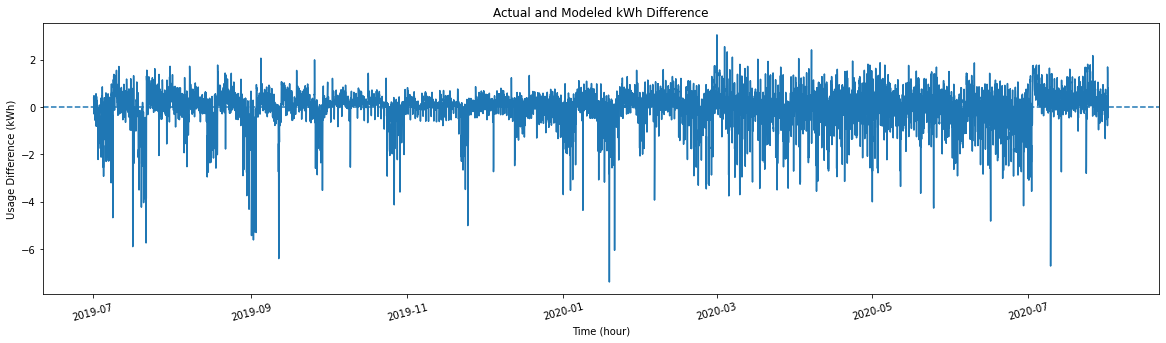

In [ ]:
# plot temperature for visualization
plt.figure(figsize=(20,5))
sns.lineplot(data=metered_savings_dataframe.metered_savings)
plt.xticks(rotation=15)
plt.axhline(0, ls='--')
plt.xlabel('Time (hour)')
plt.ylabel('Usage Difference (kWh)')
plt.title('Actual and Modeled kWh Difference')
plt.show()

Now to reduce the time to only three months

In [ ]:
threeMonthData_df = usageData_df[usageData_df.index > '2020-01-01']
tempF = tempF[tempF.index > '2020-01-01']


In [ ]:
# create a design matrix for occupancy and segmentation
preliminary_design_matrix = (
    eemeter.create_caltrack_hourly_preliminary_design_matrix(
        threeMonthData_df, tempF,
    )
)

# preliminary design matrix
preliminary_design_matrix.head(5)

,meter_value,temperature_mean,cdd_65,hdd_50,n_hours_dropped,n_hours_kept,hour_of_week
start,,,,,,,
2020-01-01 01:00:00+00:00,4.6,55.92020,0.0,0.0000,0.0,1.0,49
2020-01-01 02:00:00+00:00,0.8,54.66056,0.0,0.0000,0.0,1.0,50
2020-01-01 03:00:00+00:00,1.6,52.14074,0.0,0.0000,0.0,1.0,51
2020-01-01 04:00:00+00:00,2.7,51.05840,0.0,0.0000,0.0,1.0,52
2020-01-01 05:00:00+00:00,1.4,49.71560,0.0,0.2844,0.0,1.0,53


In [ ]:
# build 12 monthly models - each step from now on operates on each segment
segmentation = eemeter.segment_time_series(
    preliminary_design_matrix.index,
    'one_month'
)

In [ ]:
# assign an occupancy status to each hour of the week (0-167)
occupancy_lookup = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix,
    segmentation=segmentation,
)

occupancy_lookup.head(25)

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,False,False,False,True,False,True,False,True,NaN,NaN,NaN,NaN
1,False,False,False,False,True,False,False,True,NaN,NaN,NaN,NaN
2,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN
3,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN
4,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN
5,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN
6,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN
7,False,False,False,False,True,True,False,True,NaN,NaN,NaN,NaN
8,False,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN
9,False,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN


In [ ]:
# assign temperatures to bins
temperature_bins_hourly = eemeter.fit_temperature_bins(
    preliminary_design_matrix,
    segmentation=segmentation,
    default_bins=[40, 55, 65, 75, 85, 95, 105, 112],  # default
    min_temperature_count=10  # default
    )

temperature_bins_hourly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
bin_endpoints,,,,,,,,,,,,
40,False,True,False,False,False,False,False,False,False,False,False,False
55,True,True,True,True,False,False,False,False,False,False,False,False
65,True,True,True,True,False,False,False,False,False,False,False,False
75,False,True,True,True,True,False,False,False,False,False,False,False
85,False,False,False,True,True,True,True,False,False,False,False,False
95,False,False,False,True,True,True,True,False,False,False,False,False
105,False,False,False,False,True,True,True,False,False,False,False,False
112,False,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
# build a design matrix for each monthly segment
segmented_design_matrices = (
    eemeter.create_caltrack_hourly_segmented_design_matrices(
        preliminary_design_matrix,
        segmentation,
        occupancy_lookup,
        temperature_bins_hourly,
    )
)

In [ ]:
# build a CalTRACK hourly model
hourly_model = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices,
    occupancy_lookup,
    temperature_bins_hourly,
)

/usr/local/lib/python3.6/dist-packages/eemeter/metrics.py:43: RuntimeWarning: invalid value encountered in double_scalars
  ) ** 0.5


In [ ]:
metered_savings_dataframe, error_bands = eemeter.metered_savings(
    hourly_model, threeMonthData_df,
    tempF, with_disaggregated=True
)

KeyError: ignored

In [ ]:
model_results = eemeter.CalTRACKHourlyModelResults(
        status="SUCCESS",
        method_name="caltrack_hourly",
        model=hourly_model,
    )

In [ ]:
metered_savings_dataframe

,reporting_observed,counterfactual_usage,metered_savings
start,,,
2019-07-01 07:00:00+00:00,NaN,NaN,NaN
2019-07-01 08:00:00+00:00,0.4,0.780588,0.380588
2019-07-01 09:00:00+00:00,1.0,0.859913,-0.140087
2019-07-01 10:00:00+00:00,0.9,0.652056,-0.247944
2019-07-01 11:00:00+00:00,0.3,0.775855,0.475855
...,...,...,...
2020-08-01 02:00:00+00:00,2.4,1.943274,-0.456726
2020-08-01 03:00:00+00:00,2.0,2.246525,0.246525
2020-08-01 04:00:00+00:00,1.7,2.150060,0.450060


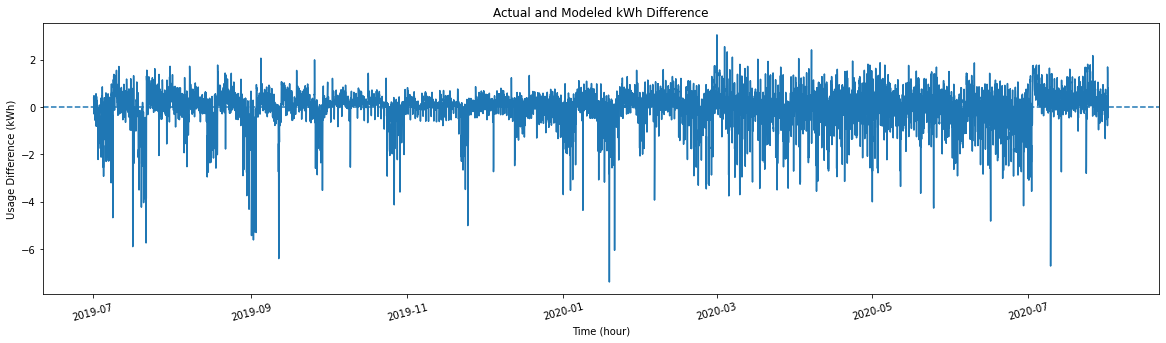

In [ ]:
# plot temperature for visualization
plt.figure(figsize=(20,5))
sns.lineplot(data=metered_savings_dataframe.metered_savings)
plt.xticks(rotation=15)
plt.axhline(0, ls='--')
plt.xlabel('Time (hour)')
plt.ylabel('Usage Difference (kWh)')
plt.title('Actual and Modeled kWh Difference')
plt.show()